In [1]:
import logging
import sys

log = logging.getLogger("P/R/ROC")
log.setLevel(logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s %(levelname)s:%(name)s %(message)s")
ch.setFormatter(formatter)

log.addHandler(ch)

log.info("Now logging")

2017-03-21 20:01:57,470 INFO:P/R/ROC Now logging


In [2]:
# MAX_TWEETS = 1_578_628
MAX_TWEETS = 100_001

# http://www.cs.ou.edu/~cgrant/teaching/cs5970sp16/sad/sad.html

import io
feature_list = []
with io.open("sad.thorn", "r", encoding='utf-8') as source:
    labels = []
    for i,line in enumerate(source.readlines()):
        if i == MAX_TWEETS: break
        elif i == 0:
            labels = line.split('þ')
        else:
            data = line.split('þ')
            feature_list.append({'id': int(data[0]), 
                                 'label': '+' if (data[1] == '1') else '-',
                                 'text' : data[2]})
#print(feature_list[0:10])

pos_tweets = [x for x in feature_list if x['label'] == '+']
neg_tweets = [x for x in feature_list if x['label'] == '-']

log.info("pos: {}, neg: {}".format(len(pos_tweets), len(neg_tweets)))


2017-03-21 20:01:58,524 INFO:P/R/ROC pos: 56462, neg: 43538


In [3]:
# Create big [({feature}, label)]
import nltk
from nltk import word_tokenize

import collections
import nltk.util
from nltk.util import ngrams

GRAM_SIZE = 1

# postive feature list
pos_features = []
for item in pos_tweets:
    for words in ngrams(word_tokenize(item['text']), GRAM_SIZE):
        word = ' '.join(words)
        pos_features.append({'feature': word})

neg_features = []
for item in neg_tweets:
    for words in ngrams(word_tokenize(item['text']), GRAM_SIZE):
        word = ' '.join(words)
        neg_features.append({'feature': word})

# Remove stop words
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
#print(stopwords)

# TODO filter tweets by stopwords
pos_features = [x for x in pos_features if x["feature"] not in stopwords]
neg_features = [x for x in neg_features if x["feature"] not in stopwords]


In [4]:
import random
from random import shuffle

SPLIT = 0.75

shuffle(pos_features)
shuffle(neg_features)

POS_TRAIN_SIZE = int(len(pos_features) * SPLIT)
NEG_TRAIN_SIZE = int(len(neg_features) * SPLIT)

train_set = [(feat, '+') for feat in pos_features[:POS_TRAIN_SIZE]]
train_set += [(feat, '-') for feat in neg_features[:NEG_TRAIN_SIZE]]

test_set = [(feat, '+') for feat in pos_features[POS_TRAIN_SIZE:]]
test_set += [(feat, '-') for feat in neg_features[NEG_TRAIN_SIZE:]]

shuffle(test_set)
shuffle(train_set)

### Naive Bayes Classifier

In [5]:
from nltk.classify import NaiveBayesClassifier

log.info("Training NB")
nb_classifier = NaiveBayesClassifier.train(train_set)
log.info("Finished Training NB. classes: {}".format(nb_classifier.labels()))


2017-03-21 20:02:31,957 INFO:P/R/ROC Training NB
2017-03-21 20:02:34,154 INFO:P/R/ROC Finished Training NB. classes: ['+', '-']


### Decision Tree Classifier

In [6]:
from nltk.classify import DecisionTreeClassifier

log.info("Training DT")
dt_classifier = DecisionTreeClassifier.train(train_set)
log.info("Finished Training DT. classes: {}".format(dt_classifier.labels()))


2017-03-21 20:02:34,161 INFO:P/R/ROC Training DT


KeyboardInterrupt: 

### MaxentClassifier

In [7]:
from nltk.classify import MaxentClassifier

log.info("Training M")
m_classifier = MaxentClassifier.train(train_set)
log.info("Finished Training M. classes: {}".format(m_classifier.labels()))

2017-03-22 09:37:08,368 INFO:P/R/ROC Training M


  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.438
             2          -0.59092        0.654
             3          -0.57451        0.654
             4          -0.56479        0.654
             5          -0.55836        0.654
             6          -0.55380        0.654
             7          -0.55039        0.654
             8          -0.54774        0.654
             9          -0.54563        0.654
            10          -0.54391        0.654
            11          -0.54248        0.654
            12          -0.54127        0.654
            13          -0.54023        0.654
            14          -0.53933        0.654
            15          -0.53854        0.654
            16          -0.53785        0.654
            17          -0.53724        0.654
            18          -0.53669        0.654
            19          -0.53619        0.654
 

2017-03-22 11:18:43,912 INFO:P/R/ROC Finished Training M. classes: ['-', '+']


         Final          -0.52868        0.654


### Get precision recall f1 measure of each (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

In [8]:
import sklearn
import sklearn.metrics
from sklearn.metrics import precision_recall_fscore_support

import numpy as np
from operator import itemgetter

def prfs(classify, test_set):
    truth = np.array([b for (a,b) in test_set])
    prediction = np.array([classify(a) for (a,b) in test_set])
    return precision_recall_fscore_support(truth, prediction)

### Run the Naive Bayes Classier

In [9]:
p,r,f1,_ = prfs(nb_classifier.classify, test_set)
log.info("nb precision: {}".format(p))
log.info("nb recall: {}".format(r))
log.info("nb f1: {}".format(f1))

2017-03-22 11:24:29,577 INFO:P/R/ROC nb precision: [ 0.60902948  0.57620809]
2017-03-22 11:24:29,578 INFO:P/R/ROC nb recall: [ 0.81051475  0.33117012]
2017-03-22 11:24:29,581 INFO:P/R/ROC nb f1: [ 0.69547305  0.42060278]


### Plotting the ROC curve (http://blog.yhat.com/posts/roc-curves.html)

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import pandas as pd
import ggplot
from ggplot import aes
from ggplot import geom_abline
from ggplot import geom_line
from ggplot import ggplot
from ggplot import ggtitle
import matplotlib.pyplot as plt

# An iPython directive for inline graphs
%matplotlib inline 

def plus2one(x): return 1 if x == '+' else 0

def plot(classify, test_set):
    truth = [plus2one(b) for (a,b) in test_set]
    data = [plus2one(classify(a)) for (a,b) in test_set]
    fpr, tpr, thresholds = roc_curve(truth, data, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    
    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
    g = ggplot(df, aes(x='fpr', y='tpr' )) + geom_line() + geom_abline(linetype='dashed')
    g += ggtitle("ROC Curve: AUC({})".format(roc_auc))
    return g

def matplot(classify, test_set):
    truth = [plus2one(b) for (a,b) in test_set]
    data = [plus2one(classify(a)) for (a,b) in test_set]
    fpr, tpr, thresholds = roc_curve(truth, data, drop_intermediate=False)
    
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    return plt

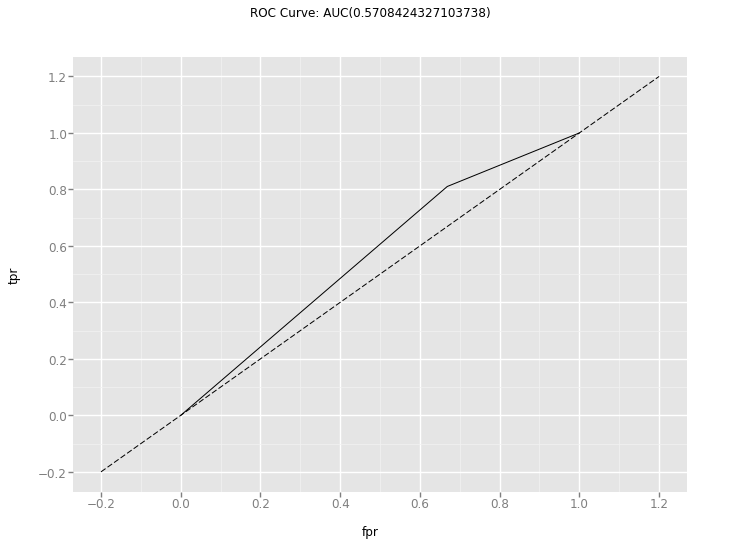

<ggplot: (320277708)>

In [13]:
plot(nb_classifier.classify, test_set)

### Run the Decision Tree Classifier

In [ ]:
p,r,f1,_ = prfs(dt_classifier.classify, test_set)
log.info("dt precision: {}".format(p))
log.info("dt recall: {}".format(r))
log.info("dt f1: {}".format(f1))

In [ ]:
plot(dt_classifier.classify, test_set)

### Run the Maxent Classifier

In [11]:
p,r,f1,_ = prfs(m_classifier.classify, test_set)
log.info("m precision: {}".format(p))
log.info("m recall: {}".format(r))
log.info("m f1: {}".format(f1))

2017-03-22 11:24:40,572 INFO:P/R/ROC m precision: [ 0.61546108  0.53321895]
2017-03-22 11:24:40,573 INFO:P/R/ROC m recall: [ 0.70407625  0.43453146]
2017-03-22 11:24:40,574 INFO:P/R/ROC m f1: [ 0.65679313  0.47884332]


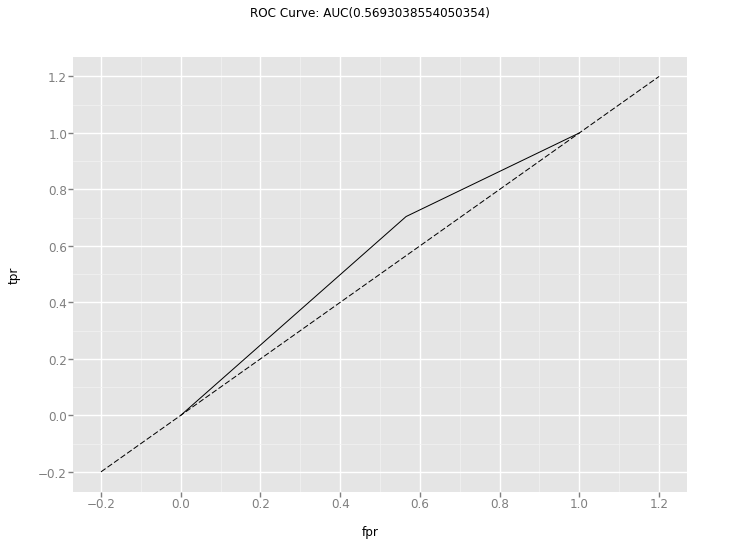

<ggplot: (-9223372036538259452)>

In [12]:
plot(m_classifier.classify, test_set)